# Проект 5. Классификация изображений автомобилей

In [1]:
# Финальная версия - используем autopep8. Недеюсь ничего не сломается...

In [ ]:
!nvidia-smi

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras import *
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [3]:
!pip freeze > requirements.txt

# Основные настройки

In [25]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS = 10  # эпох на обучение
BATCH_SIZE = 32
VAL_SPLIT = 0.15
LR = 0.001

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE = 230  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/"  # рабочая директория

In [5]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH, exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

In [ ]:
train_df.info()

In [ ]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

In [10]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip, "r") as z:
        z.extractall(PATH)

print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

In [ ]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

Задействуем продвинутую библиотеку аугментации изображений Albumentations через ImageDataAugmentor

In [15]:
!pip install git+https: // github.com/mjkvaak/ImageDataAugmentor
!pip install albumentations - -upgrade

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-fzwv3d2f
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-fzwv3d2f
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=c0c5fc471bb202cddbb5c32b266cf2dc25ba2ad273e8cb722c5a3091c186ae0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-q9n1cp8g/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
     |████████████████████████████████| 98 kB 683 kB/s eta 0:00:01
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.0.1
    Uninstalling albumentations-1.0.1:
      Successfully uninstalled albumentations-1.0.1


In [16]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

In [17]:
# все аугментации
transform = A.Compose([

    A.HueSaturationValue(always_apply=False, p=0.2, hue_shift_limit=(-20, 20),
                         sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
    A.Blur(always_apply=False, p=0.2, blur_limit=(3, 9)),
    A.CLAHE(always_apply=False, p=0.2, clip_limit=(
        1, 10), tile_grid_size=(8, 8)),
    A.ChannelShuffle(always_apply=False, p=0.2),
    A.Equalize(always_apply=False, p=0.2, mode='cv', by_channels=True),
    A.GaussNoise(always_apply=False, p=0.2, var_limit=(10.0, 80.0)),
    A.ISONoise(always_apply=False, p=0.2, intensity=(
        0.1, 0.5), color_shift=(0.01, 0.05)),
    A.ImageCompression(always_apply=False, p=0.2, quality_lower=60,
                       quality_upper=100, compression_type=0),
    A.JpegCompression(always_apply=False, p=0.2,
                      quality_lower=80, quality_upper=100),
    A.RGBShift(always_apply=False, p=0.2, r_shift_limit=(-20, 20),
               g_shift_limit=(-20, 20), b_shift_limit=(-20, 20))

])

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:915: FutureWarning: This class has been deprecated. Please use ImageCompression
  FutureWarning,


In [18]:
# добавим preprocessing для Xception и EfficientNet
train_datagen = ImageDataAugmentor(
    #rescale=1. / 255,
    # preprocess_input=xception.preprocess_input,
    preprocess_input=efficientnet.preprocess_input,
    augment=transform,
    validation_split=VAL_SPLIT,  # set validation split
    seed=RANDOM_SEED
)

test_datagen = ImageDataAugmentor(
    #rescale=1. / 255
    # preprocess_input=xception.preprocess_input,
    preprocess_input=efficientnet.preprocess_input,
    seed=RANDOM_SEED
)

### Генерация данных

In [19]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training')

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation')

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


# Построение модели. Fine-tuning

### Загружаем предобученную сеть:

In [20]:
# Версия 1: Xception

#base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

# Версия 2: EfficientNet

base_model = EfficientNetB3(
    weights='imagenet', include_top=False, input_shape=input_shape)

43941888/43941136 [==============================] - 0s 0us/step


### Формируем функцию для предварительной оценки эффективности модели и проверки после обучения:

In [45]:
def eval_model(test_model, thorough=0):
    scores = model.evaluate(test_generator, steps=1, verbose=1)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    if thorough != 0:
        plt.figure(figsize=(10, 5))
        # plt.style.use('dark_background')
        acc = test_model.history['accuracy']
        val_acc = test_model.history['val_accuracy']
        loss = test_model.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'g', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()

        # plt.figure()
        plt.figure(figsize=(10, 5))
        # plt.style.use('dark_background')
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'g', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

## Этап 1
### Замораживаем основную сеть для fine-tuning:

In [22]:
base_model.trainable = False

### Используем ExponentialDecay для контроля над learnging rate:

In [129]:
LR = ExponentialDecay(initial_learning_rate=0.001,
                      decay_steps=10000, decay_rate=0.9)

In [131]:
# Устанавливаем новую "голову"
model = Sequential([
    base_model,  # предобученная нейросеть
    GlobalAveragePooling2D(),

    Dense(128),
    BatchNormalization(axis=1),
    Activation('relu'),
    Dropout(0.25),

    Dense(10)
])

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(LR),
    metrics='accuracy'
)

In [132]:
# Настраиваем callback'и

checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5, restore_best_weights=True)

callbacks_list = [checkpoint, earlystop]

In [133]:
eval_model(model)

1/1 [==============================] - 5s 5s/step - loss: 2.3730 - accuracy: 0.0938
Accuracy: 9.38%


In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

In [ ]:
model.summary()

In [137]:
# обучаем голову

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    callbacks=callbacks_list
)

Epoch 1/10
414/414 [==============================] - 223s 527ms/step - loss: 0.9534 - accuracy: 0.6663 - val_loss: 0.6627 - val_accuracy: 0.7660

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
414/414 [==============================] - 219s 529ms/step - loss: 0.6771 - accuracy: 0.7611 - val_loss: 0.5912 - val_accuracy: 0.7810

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
414/414 [==============================] - 219s 529ms/step - loss: 0.6331 - accuracy: 0.7738 - val_loss: 0.5585 - val_accuracy: 0.7909

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
414/414 [==============================] - 216s 523ms/step - loss: 0.6110 - accuracy: 0.7790 - val_loss: 0.5673 - val_accuracy: 0.7888

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
414/414 [==============================] - 218s 528ms/step - loss: 0.5877 - accuracy: 0.7871 - val_loss: 0.5321 - val_accuracy: 0.8038

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
414/414 [====================

In [37]:
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

1/1 [==============================] - 1s 541ms/step - loss: 0.5277 - accuracy: 0.8125
Accuracy: 81.25%


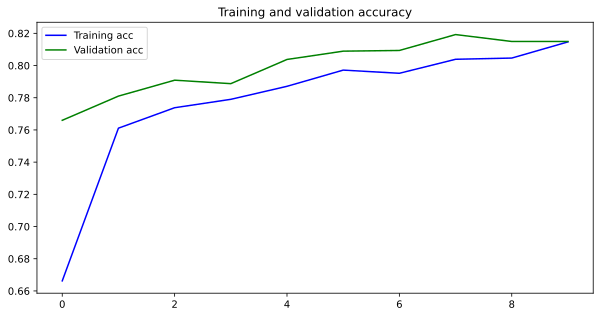

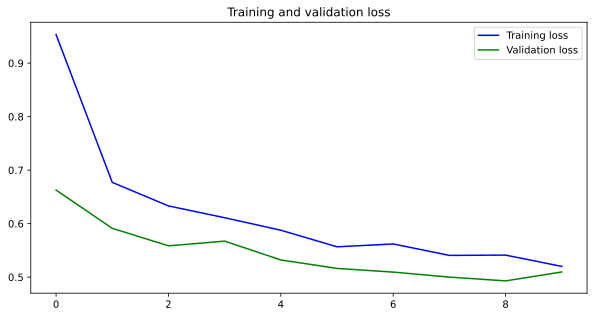

In [138]:
eval_model(history, 1)

In [ ]:
# scores = model.evaluate_generator(test_generator, steps=1, verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))

## Этап 2

### Размораживаем половину основной сети

In [106]:
print("Number of layers in the base model: ", len(
    base_model.layers), '\n1/2 = ', len(base_model.layers)//2)

Number of layers in the base model:  384 
1/2 =  192


In [139]:
base_model.layers[191:195]

In [140]:
# остановимся на сверточном слое, не задевая BatchNormalization
base_model.trainable = True

for layer in base_model.layers[:192]:
    layer.trainable = False

In [141]:
len(base_model.trainable_variables)

171

In [142]:
LR = ExponentialDecay(initial_learning_rate=0.0001,
                      decay_steps=1000, decay_rate=0.9)

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(LR),
    metrics='accuracy'
)

In [143]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 8, 8, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               196736    
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

In [144]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    callbacks=callbacks_list
)

Epoch 1/10
414/414 [==============================] - 244s 564ms/step - loss: 0.5419 - accuracy: 0.8052 - val_loss: 0.3404 - val_accuracy: 0.8751

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
414/414 [==============================] - 228s 550ms/step - loss: 0.2858 - accuracy: 0.9011 - val_loss: 0.2786 - val_accuracy: 0.9021

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
414/414 [==============================] - 227s 548ms/step - loss: 0.2186 - accuracy: 0.9236 - val_loss: 0.2137 - val_accuracy: 0.9236

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
414/414 [==============================] - 229s 554ms/step - loss: 0.1582 - accuracy: 0.9476 - val_loss: 0.2233 - val_accuracy: 0.9249

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
414/414 [==============================] - 229s 554ms/step - loss: 0.1256 - accuracy: 0.9587 - val_loss: 0.1982 - val_accuracy: 0.9326

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
414/414 [====================

In [145]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

1/1 [==============================] - 1s 510ms/step - loss: 0.1232 - accuracy: 0.9375
Accuracy: 93.75%


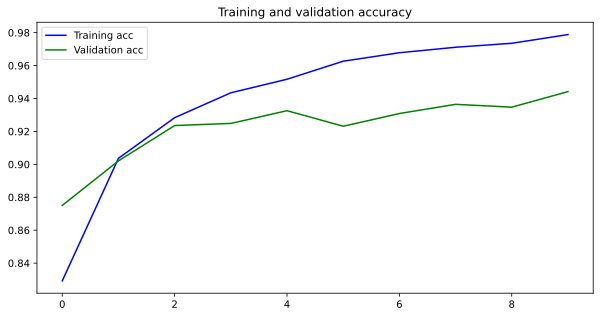

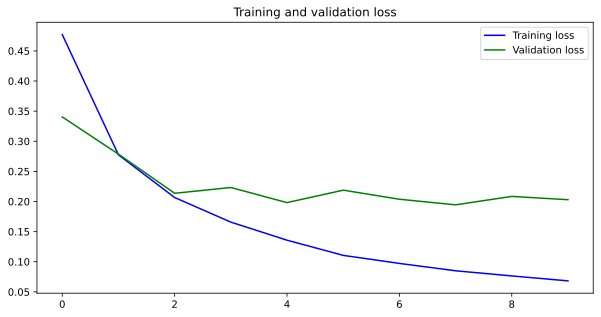

In [146]:
eval_model(history, 1)

## Этап 3

### Размораживаем всю сеть

In [147]:
base_model.trainable = True

In [148]:
LR = ExponentialDecay(initial_learning_rate=0.00001,
                      decay_steps=1000, decay_rate=0.9)

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(LR),
    metrics='accuracy'
)

In [149]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 8, 8, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               196736    
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

In [150]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    callbacks=callbacks_list
)

Epoch 1/10
414/414 [==============================] - 286s 659ms/step - loss: 0.0780 - accuracy: 0.9749 - val_loss: 0.1744 - val_accuracy: 0.9468

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
414/414 [==============================] - 273s 659ms/step - loss: 0.0682 - accuracy: 0.9772 - val_loss: 0.1768 - val_accuracy: 0.9511

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
414/414 [==============================] - 271s 654ms/step - loss: 0.0657 - accuracy: 0.9795 - val_loss: 0.1960 - val_accuracy: 0.9425

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
414/414 [==============================] - 272s 657ms/step - loss: 0.0559 - accuracy: 0.9816 - val_loss: 0.2000 - val_accuracy: 0.9459

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
414/414 [==============================] - 272s 655ms/step - loss: 0.0521 - accuracy: 0.9851 - val_loss: 0.1680 - val_accuracy: 0.9493

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
414/414 [====================

In [151]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

1/1 [==============================] - 1s 516ms/step - loss: 0.2419 - accuracy: 0.9062
Accuracy: 90.62%


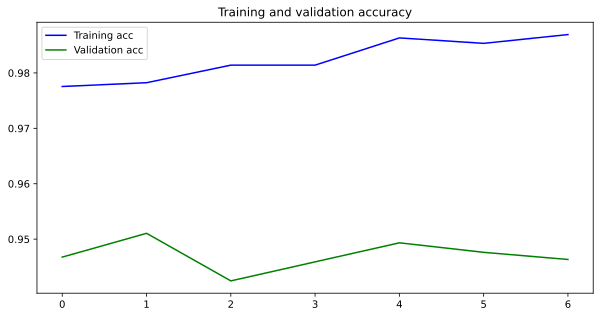

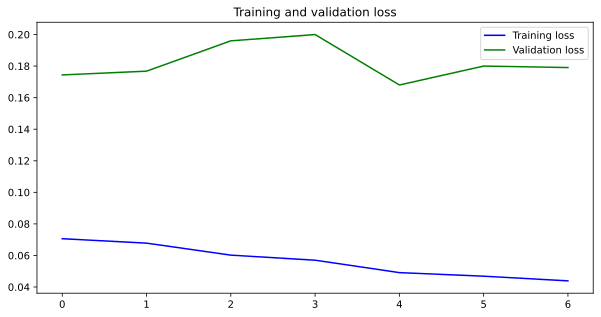

In [152]:
eval_model(history, 1)

## Дообучение на увеличенных изображениях (реализовано, на практике не использовано)

In [ ]:
LR = ExponentialDecay(initial_learning_rate=0.0001,
                      decay_steps=1000, decay_rate=0.9)
BATCH_SIZE = 12
IMG_SIZE = 520
EPOCHS = 5

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(LR),
    metrics='accuracy'
)

In [ ]:
# model.summary()

In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    callbacks=callbacks_list
)

In [ ]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
eval_model(history)

# Submit

Формируем сабмит без TTA:

In [153]:
test_sub_generator.samples

6675

In [154]:
test_sub_generator.reset()
predictions = model.predict(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

209/209 [==============================] - 38s 172ms/step


In [155]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission2.csv', index=False)
print('Save submit')

Save submit


In [156]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


Используем TTA:

In [158]:
# генерируем новые аугментированные данные
test_datagen = ImageDataAugmentor(
    #rescale=1. / 255,
    # preprocess_input=xception.preprocess_input,
    preprocess_input=efficientnet.preprocess_input,
    augment=transform,
    validation_split=VAL_SPLIT,  # set validation split
    seed=RANDOM_SEED
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='./car/test_upload',
    x_col='Id',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=12,
    class_mode=None,
    shuffle=False,
)

Found 6675 validated image filenames.


In [159]:
NUM_PREDICTIONS_FOR_TTA = EPOCHS
predictions_TTA = []

for i in range(NUM_PREDICTIONS_FOR_TTA):
    temp_predict = model.predict(test_generator, verbose=1)
    predictions_TTA.append(temp_predict)

final_TTA_prediction = np.mean(np.array(predictions_TTA), axis=0)

557/557 [==============================] - 95s 171ms/step


In [160]:
final_TTA_prediction[:2]

array([[-2.6323988 , -2.943652  , -1.3325307 , -5.033284  , -4.748821  ,
        -3.278592  , -0.5919451 ,  4.375734  , -3.4338753 ,  0.26894954],
       [ 3.124729  ,  2.0866315 , -3.1820872 , -4.897589  , -8.298121  ,
        -3.9286082 ,  8.338158  , -4.3777866 , -2.279352  , -7.1081257 ]],
      dtype=float32)

In [161]:
predictions = np.argmax(final_TTA_prediction, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

In [162]:
filenames_with_dir = test_generator.filenames
submission = pd.DataFrame({'Id': filenames_with_dir,
                           'Category': predictions},
                          columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission_2_TTA.csv', index=False)
print('Save submit')

Save submit


In [163]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)